In [2]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
from Dataset import *
from Visual import *


In [3]:
ANNOTATIONS_FILE = "/home/vitalex93/Desktop/Data_Science/Deep_Learning/DLproject/Data/features_30_sec.csv"
AUDIO_DIR = "/home/vitalex93/Desktop/Data_Science/Deep_Learning/DLproject/Data/genres_original/"
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)
md = MusicSoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram,
                        SAMPLE_RATE, NUM_SAMPLES)
print(f"There are {len(md)} samples in the dataset.")
signal, label = md[10]


There are 1000 samples in the dataset.


In [4]:
si, sa = torchaudio.load("/home/vitalex93/Desktop/Data_Science/Deep_Learning/DLproject/Data/genres_original/blues/blues.00001.wav")
si.shape

g = torch.randn(1, 661794)
si = si + (0.1**0.5)*torch.randn(1, 661794)
si

list(si.shape)
#torch.mean(si)



[1, 661794]

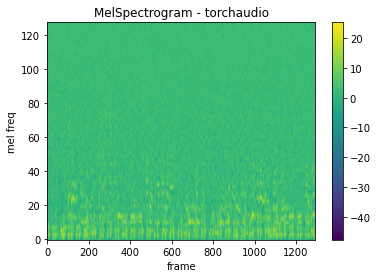

In [5]:
plot_mel(si, sa)

In [ ]:
plot_spectrogram()